# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_columns', 500)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer 


from pylab import rcParams

from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import itertools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import pickle

 


In [2]:
!pip install imbalanced-learn


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
customers = pd.read_csv('costumers_all.csv', sep=';')

/home/lexlabs/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias = pd.read_csv('azdias_all.csv', sep=';')

/home/lexlabs/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
azdias = azdias.sample(100000)
customers = customers.sample(50000)

In [6]:
description = pd.read_csv('az_dias_description.csv', sep=';')

In [7]:
def print_shape_df(df,name):
    nrows, ncols = df.shape
    print(name)
    print("Number of rows: ",nrows)
    print("Number of features: ",ncols)

#print_shape_df(azdias,"AZDIAS")
#print_shape_df(customers,"CUSTOMERS")
#print_shape_df(description,"DESCRIPTION")

In [8]:
columns_to_drop = set(azdias.columns)-set(description["Attribute"].values)
azdias.drop(columns=columns_to_drop,inplace=True)
customers.drop(columns=columns_to_drop,inplace=True)

In [9]:
print(set(azdias.columns)-set(customers.columns))
print(set(customers.columns)-set(azdias.columns))
print(set(azdias.columns)-set(description["Attribute"].values))
print(set(description["Attribute"].values)-set(azdias.columns))
print(len(set(azdias.columns)-set(description["Attribute"].values)))
print(len(set(description["Attribute"].values)-set(azdias.columns)))


set()
{'ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP'}
set()
{'D19_DIGIT_SERV_RZ', 'D19_SCHUHE_RZ', 'HAUSHALTSSTRUKTUR', 'D19_KINDERARTIKEL_RZ', 'D19_WEIN_FEINKOST_RZ', 'D19_BILDUNG_RZ', 'SOHO_FLAG', 'D19_BANKEN_GROSS_RZ', 'D19_GARTEN_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_BANKEN_REST_RZ', 'D19_SAMMELARTIKEL_RZ', 'D19_HANDWERK_RZ', 'D19_ENERGIE_RZ', 'D19_TELKO_MOBILE_RZ', 'D19_TECHNIK_RZ', 'D19_TIERARTIKEL_RZ', 'D19_HAUS_DEKO_RZ', 'D19_RATGEBER_RZ', 'D19_TELKO_REST_RZ', 'D19_FREIZEIT_RZ', 'D19_SONSTIGE_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BUCH_RZ', 'D19_KK_KUNDENTYP', 'D19_DROGERIEARTIKEL_RZ', 'D19_VOLLSORTIMENT_RZ', 'D19_LOTTO_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_REISEN_RZ', 'GEOSCORE_KLS7', 'D19_VERSAND_REST_RZ', 'WACHSTUMSGEBIET_NB', 'BIP_FLAG', 'D19_BANKEN_DIREKT_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'KBA13_CCM_1400_2500', 'D19_BIO_OEKO_RZ', 'D19_VERSICHERUNGEN_RZ', 'D19_KOSMETIK_RZ'}
0
41


In [48]:
def pre_processing(df):
    import datetime
    import math
    
    if("Unnamed: 0" in df.columns):
        df.drop(columns=["Unnamed: 0"],inplace=True)
        
    if("LNR" in df.columns):
        df.set_index("LNR",inplace=True)
        
    #TOO MANY VALUES
    if("D19_LETZTER_KAUF_BRANCHE" in df.columns):
        df.drop(columns = ["D19_LETZTER_KAUF_BRANCHE"],inplace=True)
    
    def map_year(x):
        x = str(x)
        year = x.split("-")[0]
        return year
    
    
        
    def map_cameo_deu(x):
        letter = x[1]
        letter_dict = {"A":1,"B":2,"C":3,"D":4,"E":5,"F":6}
        return letter_dict[letter]
        
    df["CAMEO_DEU_2015_LETTER"] = df["CAMEO_DEU_2015"].apply(lambda x: np.nan if (x=="XX" or x=="X" or x=="" or x==" " or str(x)=="nan") else map_cameo_deu(x)).astype(float)
    df["CAMEO_DEUG_2015"] = df["CAMEO_DEUG_2015"].apply(lambda x: np.nan if (x=="XX" or x=="X" or x=="" or x==" " or str(x)=="nan") else x).astype(float)
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].apply(lambda x: np.nan if (x=="XX" or x=="X" or x=="" or x==" " or str(x)=="nan") else x).astype(float)
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].map({"W":0,"O":1,np.nan:np.nan}).astype(float)
    df["EINGEFUEGT_AM"] = df["EINGEFUEGT_AM"].apply(lambda x: map_year(x) if str(x)!="nan" else map_year(x)).astype(float)
    
    
    return df


def feature_eng(df):

    #WOHNLAGE
    area_dict = {1.0:0, 2.0:0, 3.0:0, 4.0:0, 5.0:0, 7.0:1, 8.0:1}
    #WOHNLAGE
    quality_dict = {1.0:1, 2.0:1, 3.0:2, 4.0:3, 5.0:3,7:-1,8:-1}
     
    df["WOHNLAGE_URBAN_OR_RURAL"] = df["WOHNLAGE"].map(area_dict).astype(float)
    df["WOHNLAGE_QUALITY"] = df["WOHNLAGE"].map(quality_dict).astype(float)
       
    #LP_STATUS_GROB
    social_status_dict = {1:0,2:0,3:1,4:1,5:1,6:2,7:2,8:3,9:3,10:4}
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(social_status_dict).astype(float)

    #LP_FAMILIE_GROB
    family_size = {1:0,2:1,3:2,4:2,5:2,6:3,7:3,8:3,9:4,10:4,11:4}
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(family_size).astype(float)
    
    

    transactions_mail_order_array = ["D19_VERSAND_ONLINE_QUOTE_12",
                                     "D19_BANKEN_ONLINE_QUOTE_12",
                                     "D19_GESAMT_ONLINE_QUOTE_12"]

    transactions_mail_order = {0:0,1:1,2:1,3:1,4:2,5:2,6:2,7:2,8:2,9:2,10:3}
    
    for tmo in transactions_mail_order_array:
        df[tmo] = df[tmo].map(transactions_mail_order).astype(float)



    transactions_online_array = ["D19_BANKEN_DATUM",
    "D19_BANKEN_OFFLINE_DATUM",
    "D19_BANKEN_ONLINE_DATUM",
    "D19_GESAMT_DATUM",
    "D19_GESAMT_OFFLINE_DATUM",
    "D19_GESAMT_ONLINE_DATUM",
    "D19_TELKO_DATUM",
    "D19_TELKO_OFFLINE_DATUM",
    "D19_TELKO_ONLINE_DATUM",
    "D19_VERSAND_DATUM",
    "D19_VERSAND_OFFLINE_DATUM",
    "D19_VERSAND_ONLINE_DATUM"]

    transactions_online = {1:1,2:1,3:1,4:2,5:2,6:3,7:3,8:3,9:3,10:0} 
    for to in transactions_online_array:
        df[to] = df[to].map(transactions_online).astype(float)

    


    transactions_activity_array = ["D19_VERSI_ANZ_12",
    "D19_VERSI_ANZ_24",
    "D19_BANKEN_ANZ_12",
    "D19_BANKEN_ANZ_24",
    "D19_GESAMT_ANZ_12",
    "D19_GESAMT_ANZ_24",
    "D19_TELKO_ANZ_12",
    "D19_TELKO_ANZ_24",
    "D19_VERSAND_ANZ_12",
    "D19_VERSAND_ANZ_24"]


    transactions_activity = {0:0,1:1,2:1,3:2,4:2,5:3,6:3}
    
    
    for ta in transactions_activity_array:
        df[ta] = df[ta].map(transactions_activity).astype(float)

    def map_wealth(wealth):
        if(str(wealth)=="nan" or wealth == None):
            return np.nan
        if(wealth>=11 and wealth<=15):
            return 4
        if(wealth>=21 and wealth<=25):
            return 3
        if(wealth>=31 and wealth<=35):
            return 2
        if(wealth>=41 and wealth<=45):
            return 1
        if(wealth>=51 and wealth<=55):
            return 0

    def map_movement(x):
        if(x in [1,3,5,8,10,12,14]):
            return 1
        if(x in [2,4,6,7,9,11,13,15]):
            return 0
        else:
            return np.nan

    def map_generation():
        return {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:1,9:1,10:1,12:1,13:1,14:2,15:2}

    def map_life_stating(x):
        if(str(x)=="nan" or x==None):
            return np.nan

        return int(x)%10

    def map_status(x):
        if(str(x)=="nan" or x == None):
            return np.nan
        if(x>=1 and x<=2):
            return 4
        if(x>=3 and x<=5):
            return 3
        if(x>=6 and x<=7):
            return 2
        if(x>7):
            return 1
        
        
    df["CAMEO_INTL_2015_WEALTH"] = df["CAMEO_INTL_2015"].apply(lambda x: map_wealth(x)).astype(float)
    
    df["CAMEO_INTL_2015_LIFE_STATING"] = df["CAMEO_INTL_2015"].apply(lambda x: map_life_stating(x)).astype(float)
    
    df["CAMEO_DEUG_2015_WEALTH_STATUS"] = df["CAMEO_DEUG_2015"].apply(lambda x: map_status(x)).astype(float)

    
    df["PRAEGENDE_JUGENDJAHRE_GENERATION"] = df["PRAEGENDE_JUGENDJAHRE"].map(map_generation())
    
    df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: map_movement(x))

   
    
    
    life_age = {1: 1, 2: 2, 3: 1,
              4: 2, 5: 3, 6: 4,
              7: 3, 8: 4, 9: 2,
              10: 2, 11: 3, 12: 4,
              13: 3, 14: 1, 15: 3,
              16: 3, 17: 2, 18: 1,
              19: 3, 20: 3, 21: 2,
              22: 2, 23: 2, 24: 2,
              25: 2, 26: 2, 27: 2,
              28: 2, 29: 1, 30: 1,
              31: 3, 32: 3, 33: 1,
              34: 1, 35: 1, 36: 3,
              37: 3, 38: 4, 39: 2,
              40: 4}

    wealt_scale = {1: 1, 2: 1, 3: 2, 4: 2, 5: 1, 6: 1,
              7: 2, 8: 2, 9: 2, 10: 3, 11: 2,
              12: 2, 13: 4, 14: 2, 15: 1, 16: 2,
              17: 2, 18: 3, 19: 3, 20: 4, 21: 1,
              22: 2, 23: 3, 24: 1, 25: 2, 26: 2,
              27: 2, 28: 4, 29: 1, 30: 2, 31: 1,
              32: 2, 33: 2, 34: 2, 35: 4, 36: 2,
              37: 2, 38: 2, 39: 4, 40: 4}
    
    df['LP_LEBENSPHASE_FEIN_AGE'] = df['LP_LEBENSPHASE_FEIN'].map(life_age)
    df['LP_LEBENSPHASE_FEIN_WEALTH'] = df['LP_LEBENSPHASE_FEIN'].map(wealt_scale)

      
    #FEATURES JÀ
    df.drop(columns=["WOHNLAGE","PRAEGENDE_JUGENDJAHRE","LP_LEBENSPHASE_FEIN","CAMEO_DEUG_2015","CAMEO_INTL_2015","CAMEO_DEU_2015"],inplace=True)
        
    return df

def map_to_unkown(df):
    df_unknow_values = pd.read_csv("unknow_values.csv",sep=";")
    mapping_unkown_values = {}
    for index,row in df_unknow_values.iterrows():
        values_splitted =  row["Value"].replace(" ","").split(",")
        values_splitted =list(map(int, values_splitted))
        mapping_unkown_values[row["Attribute"]] = values_splitted
    
    
    
    data = []
    count = 0
    for index, row in df.iterrows():
        if(count%1000==0):
            print(count," rows processed")
        count+=1
        new_row = []
        for column in row.keys():
            new_value = row[column]
            if column in mapping_unkown_values.keys():
                if row[column] in mapping_unkown_values[column]:
                    new_value = np.nan
                else:
                    new_value = row[column]
            new_row.append(new_value)
        data.append(new_row)
    return pd.DataFrame(data,columns=df.columns)          





In [11]:
azdias = pre_processing(azdias)
customers = pre_processing(customers)

print_shape_df(azdias,"AZDIAS")
print_shape_df(customers,"CUSTOMERS")


AZDIAS
Number of rows:  100000
Number of features:  274
CUSTOMERS
Number of rows:  50000
Number of features:  277


In [31]:
set(customers.columns)-set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [32]:
set(azdias.columns)-set(customers.columns)

set()

In [33]:
def pre_processing_customers(customers):
    return customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],inplace=True)

In [34]:
custumers = pre_processing_customers(customers)

**Let's see the number of empty values in dataset**

In [35]:
def calculate_nan_summary(df):
    resume_isna = df.isna().sum().reset_index()
    resume_isna.columns = ["feature","NAN (%)"]
    resume_isna = resume_isna.set_index("feature")
    total = len(df)
    resume_isna["NAN (%)"] = resume_isna["NAN (%)"]*100/total
    resume_isna["NAN (%)"] = resume_isna["NAN (%)"].apply(lambda x: round(x,3))
    return resume_isna

def plot_histogram_nan_values(df,title):
    plt.suptitle(title)
    df.hist(figsize=(12,8))    


def plot_bar_chart_high_nan_values(resume_isna,threshold):
        resume_isna[resume_isna["NAN (%)"]>=threshold].plot(kind='barh', figsize=(6,10),title="% NAN values")

In [36]:
resume_isna_azdias = calculate_nan_summary(azdias)
resume_isna_costumers = calculate_nan_summary(customers)

In [43]:
resume_isna_costumers

,NAN (%)
feature,
AGER_TYP,0.000
ALTER_HH,24.196
ANZ_HAUSHALTE_AKTIV,25.978
ANZ_HH_TITEL,27.114
ANZ_PERSONEN,24.196
ANZ_TITEL,24.196
BALLRAUM,25.986
CAMEO_DEU_2015,26.230
CAMEO_DEUG_2015,26.290


<Figure size 432x288 with 0 Axes>

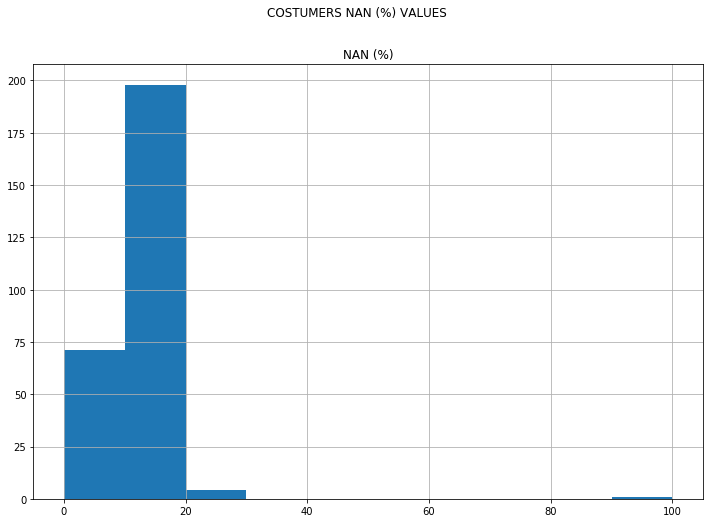

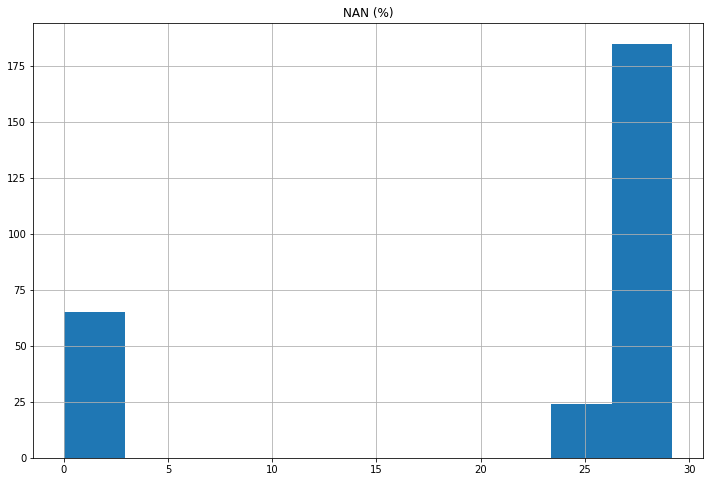

In [41]:
plot_histogram_nan_values(resume_isna_azdias,"AZDIAS NAN (%) VALUES")
plot_histogram_nan_values(resume_isna_costumers,"COSTUMERS NAN (%) VALUES")

Some columns has 60% or more missing values in the dataset of **AZDIAS**. Some has more than 90% missing values. The others, less than  30% missing values

Ploting only features with 60% or more missing values

TypeError: Empty 'DataFrame': no numeric data to plot

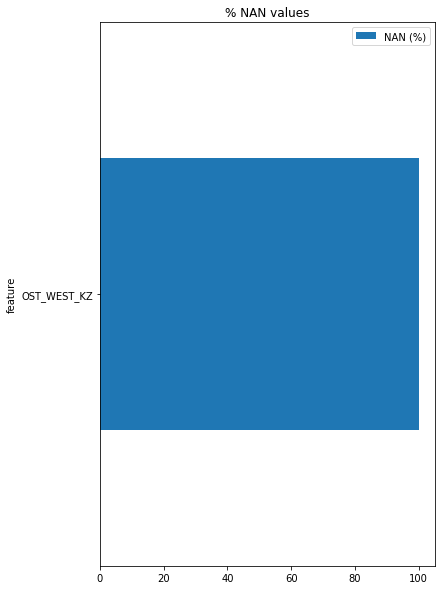

In [42]:
plot_bar_chart_high_nan_values(resume_isna_azdias,60)
plot_bar_chart_high_nan_values(resume_isna_costumers,60)

In [18]:
azdias

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13

In [44]:
azdias_step1 = map_to_unkown(azdias)
customers_step1 = map_to_unkown(customers)

0  rows processed
1000  rows processed
2000  rows processed
3000  rows processed
4000  rows processed
5000  rows processed
6000  rows processed
7000  rows processed
8000  rows processed
9000  rows processed
10000  rows processed
11000  rows processed
12000  rows processed
13000  rows processed
14000  rows processed
15000  rows processed
16000  rows processed
17000  rows processed
18000  rows processed
19000  rows processed
20000  rows processed
21000  rows processed
22000  rows processed
23000  rows processed
24000  rows processed
25000  rows processed
26000  rows processed
27000  rows processed
28000  rows processed
29000  rows processed
30000  rows processed
31000  rows processed
32000  rows processed
33000  rows processed
34000  rows processed
35000  rows processed
36000  rows processed
37000  rows processed
38000  rows processed
39000  rows processed
40000  rows processed
41000  rows processed
42000  rows processed
43000  rows processed
44000  rows processed
45000  rows processed
4

In [ ]:
#azdias_step1.to_pickle("azdias_step1.pkl")
#customers_step1.to_pickle("customers_step1.pkl")
#azdias_step1 = pd.read_pickle("azdias_step1.pkl")
#customers_step1 = pd.read_pickle("customers_step1.pkl")

In [45]:
azdias_step1 = feature_eng(azdias_step1)
customers_step1 = feature_eng(customers_step1)

In [46]:
resume_isna_azdias_step1 = calculate_nan_summary(azdias_step1)
resume_isna_costumers_step1 = calculate_nan_summary(customers_step1)

<Figure size 432x288 with 0 Axes>

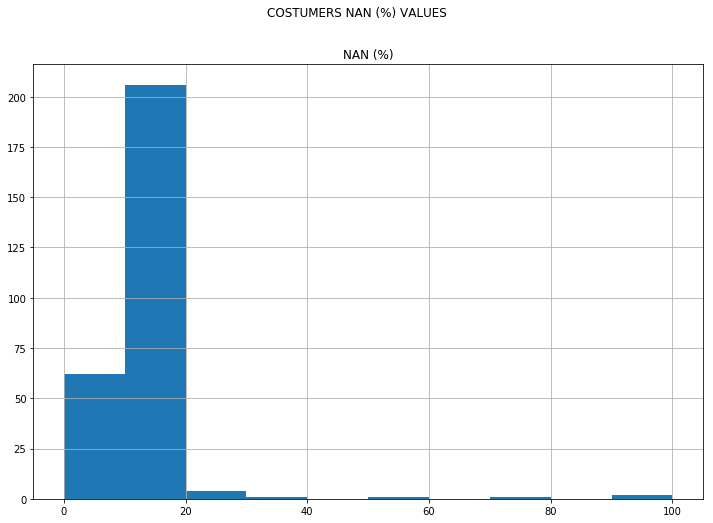

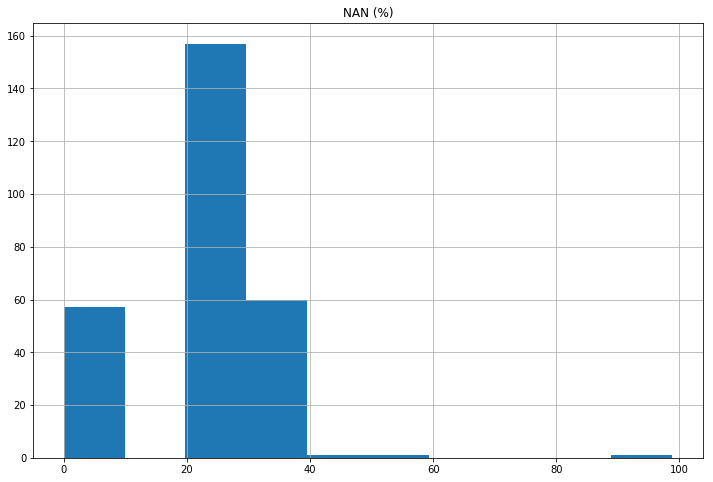

In [47]:
plot_histogram_nan_values(resume_isna_azdias_step1,"AZDIAS NAN (%) VALUES")
plot_histogram_nan_values(resume_isna_costumers_step1,"COSTUMERS NAN (%) VALUES")

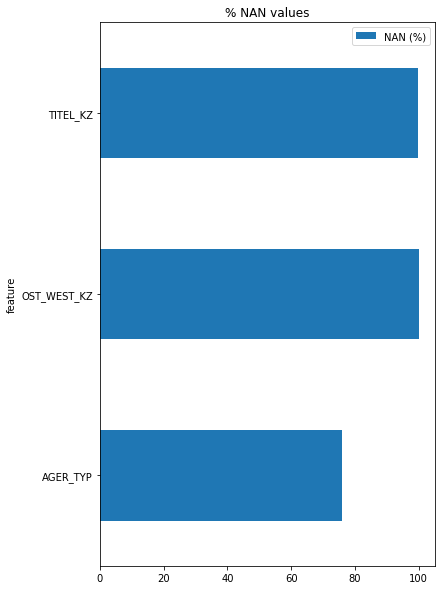

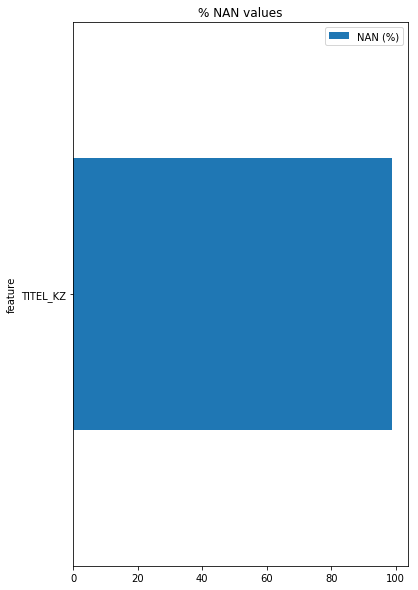

In [48]:
plot_bar_chart_high_nan_values(resume_isna_azdias_step1,60)
plot_bar_chart_high_nan_values(resume_isna_costumers_step1,60)

In [49]:
def drop_high_missing_values_columns(df,resumed_isna,thresold=30):
    high_missing_values_features = list(resumed_isna[resumed_isna["NAN (%)"]>=thresold].index)
    return df.drop(columns=high_missing_values_features)

In [50]:
resume_isna_azdias_step1

,NAN (%)
feature,
AGER_TYP,76.036
ALTER_HH,34.773
ANZ_HAUSHALTE_AKTIV,10.577
ANZ_HH_TITEL,10.970
ANZ_PERSONEN,8.265
ANZ_TITEL,8.265
BALLRAUM,10.646
CJT_GESAMTTYP,0.593
D19_BANKEN_ANZ_12,0.000


In [51]:
azdias_step2 = drop_high_missing_values_columns(azdias_step1,resume_isna_azdias_step1)
customers_step2 = drop_high_missing_values_columns(customers_step1,resume_isna_costumers_step1)

In [52]:
print_shape_df(azdias_step2,"AZDIAS")
print_shape_df(customers_step2,"COSTUMERS")

AZDIAS
Number of rows:  100000
Number of features:  272
COSTUMERS
Number of rows:  50000
Number of features:  271


In [53]:
set(set(azdias.columns)-set(azdias_step2.columns))-set(["WOHNLAGE","PRAEGENDE_JUGENDJAHRE","LP_LEBENSPHASE_FEIN","CAMEO_DEUG_2015","CAMEO_INTL_2015","CAMEO_DEU_2015"])

{'AGER_TYP', 'ALTER_HH', 'KBA05_BAUMAX', 'OST_WEST_KZ', 'TITEL_KZ'}

In [54]:
set(set(customers.columns)-set(customers_step2.columns))-set(["WOHNLAGE","PRAEGENDE_JUGENDJAHRE","LP_LEBENSPHASE_FEIN","CAMEO_DEUG_2015","CAMEO_INTL_2015","CAMEO_DEU_2015"])

{'AGER_TYP', 'ALTER_HH', 'KBA05_BAUMAX', 'KKK', 'REGIOTYP', 'TITEL_KZ'}

In [55]:
set(set(azdias_step1.columns)-set(azdias.columns))

{'CAMEO_DEUG_2015_WEALTH_STATUS',
 'CAMEO_INTL_2015_LIFE_STATING',
 'CAMEO_INTL_2015_WEALTH',
 'LP_LEBENSPHASE_FEIN_AGE',
 'LP_LEBENSPHASE_FEIN_WEALTH',
 'PRAEGENDE_JUGENDJAHRE_GENERATION',
 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
 'WOHNLAGE_QUALITY',
 'WOHNLAGE_URBAN_OR_RURAL'}

In [56]:
def calculate_missing_values_per_row(df):
    missing_values_per_row = df.isnull().transpose().sum().reset_index()
    missing_values_per_row.columns = ["line","Number of Missing Values"]
    missing_values_per_row["% of Missing Values"] = missing_values_per_row["Number of Missing Values"]/len(df.columns)*100
    missing_values_per_row.set_index("line",inplace=True)
    return missing_values_per_row



def plot_number_missing_values_per_row(df,column):    
    df[[column]].hist(figsize=(8,6))

In [57]:
missing_values_per_row_azdias = calculate_missing_values_per_row(azdias_step2)
missing_values_per_row_customers = calculate_missing_values_per_row(customers_step2)

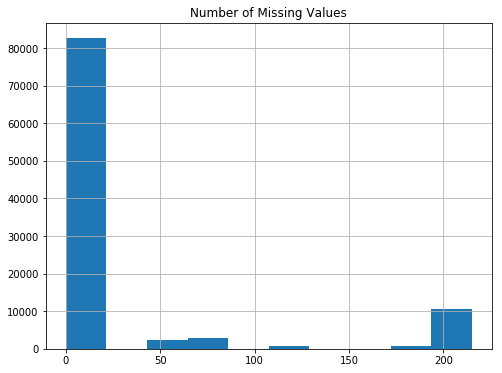

In [58]:
plot_number_missing_values_per_row(missing_values_per_row_azdias,"Number of Missing Values")


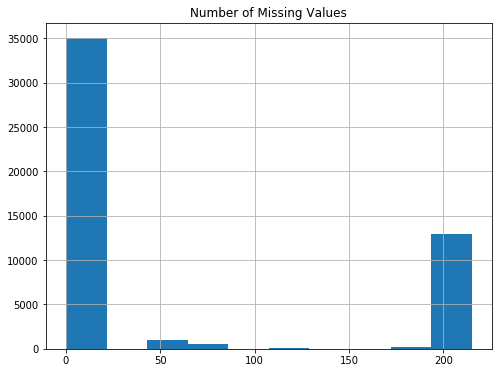

In [59]:
plot_number_missing_values_per_row(missing_values_per_row_customers,"Number of Missing Values")

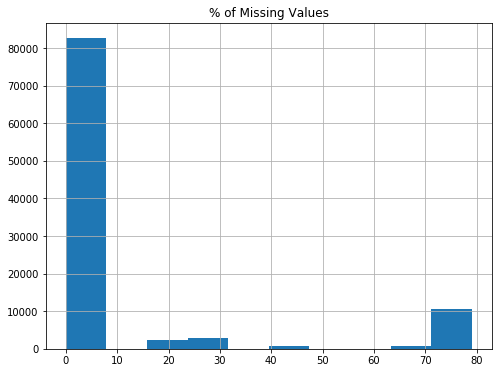

In [60]:
plot_number_missing_values_per_row(missing_values_per_row_azdias,"% of Missing Values")

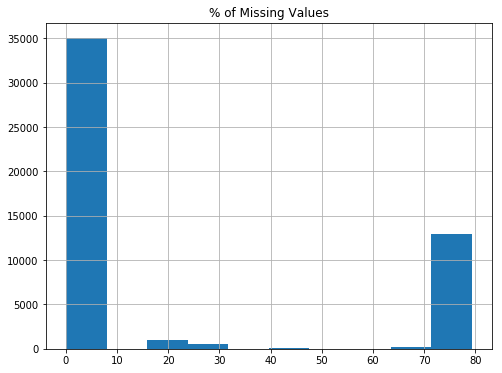

In [61]:
plot_number_missing_values_per_row(missing_values_per_row_customers,"% of Missing Values")

In [62]:
def drop_high_missing_rows(df,missing_values_per_row,thresold=50):
    return df[df.index.isin(list(missing_values_per_row[missing_values_per_row["% of Missing Values"]<=thresold].index))]

In [63]:
azdias_step3 = drop_high_missing_rows(azdias_step2,missing_values_per_row_azdias)
customers_step3 = drop_high_missing_rows(customers_step2,missing_values_per_row_customers)

In [64]:
print_shape_df(azdias_step3,"AZDIAS")
print_shape_df(customers_step3,"COSTUMERS")

AZDIAS
Number of rows:  88701
Number of features:  272
COSTUMERS
Number of rows:  36781
Number of features:  271


In [65]:
az_dias_description = pd.read_csv("az_dias_description.csv",sep=";")

In [66]:
az_dias_description[az_dias_description["Type"]=="categorical"].head(5)

,Attribute,Description,Type
0,AGER_TYP,best-ager typology,categorical
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,categorical
2,ALTER_HH,main age within the household,categorical
3,ANREDE_KZ,gender,categorical
8,BALLRAUM,distance to next urban centre,categorical


In [67]:
azdias_step2

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_DEU_2015_LETTER,WOHNLAGE_URBAN_OR_RURAL,WOHNLAGE_QUALITY,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STATI

In [68]:
def plot_bar(df,categoric_columns_examples,title):
    total = len(df)
    df_grouped = df.groupby(categoric_columns_examples)["ALTERSKATEGORIE_GROB"].count().reset_index().rename(columns={"ALTERSKATEGORIE_GROB":"Count"})
    df_grouped["%Population"] = df_grouped["Count"]/total*100
    plt.figure(figsize=(15,4))
    sns.barplot(x=categoric_columns_examples[0],y="%Population",hue=categoric_columns_examples[1],data=df_grouped).set_title(title)

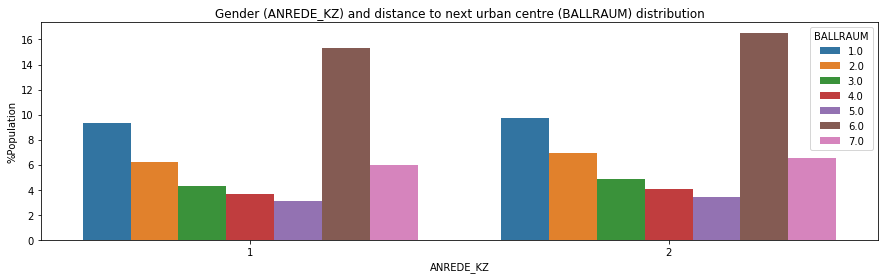

In [69]:
title = 'Gender (ANREDE_KZ) and distance to next urban centre (BALLRAUM) distribution'
categoric_columns_examples = ["ANREDE_KZ","BALLRAUM"]
plot_bar(azdias_step3,categoric_columns_examples,title)


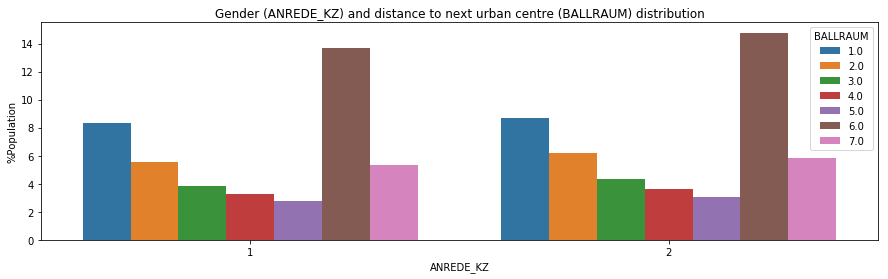

In [70]:
title = 'Gender (ANREDE_KZ) and distance to next urban centre (BALLRAUM) distribution'
categoric_columns_examples = ["ANREDE_KZ","BALLRAUM"]
plot_bar(azdias,categoric_columns_examples,title)


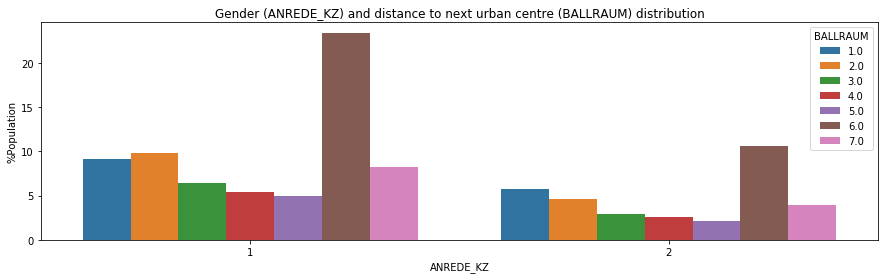

In [71]:
title = 'Gender (ANREDE_KZ) and distance to next urban centre (BALLRAUM) distribution'
categoric_columns_examples = ["ANREDE_KZ","BALLRAUM"]
plot_bar(customers_step3,categoric_columns_examples,title)


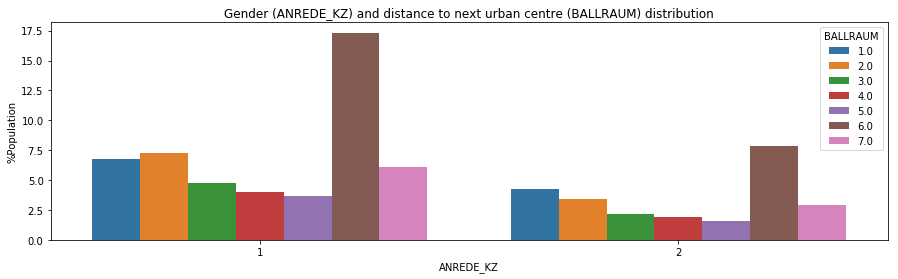

In [72]:
title = 'Gender (ANREDE_KZ) and distance to next urban centre (BALLRAUM) distribution'
categoric_columns_examples = ["ANREDE_KZ","BALLRAUM"]
plot_bar(customers,categoric_columns_examples,title)


In [73]:
az_dias_description_numeric = az_dias_description[az_dias_description["Type"]=="numeric"]
numeric_columns = list(az_dias_description_numeric.Attribute)
az_dias_description_numeric

,Attribute,Description,Type
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,numeric
5,ANZ_HH_TITEL,number of academic title holder in building,numeric
6,ANZ_PERSONEN,number of adult persons in the household,numeric
7,ANZ_TITEL,number of professional title holder in household,numeric
85,GEBURTSJAHR,year of birth,numeric


In [74]:
#pd.set_option('display.max_columns', 500)
azdias_step3[numeric_columns].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR
count,88701.000000,88317.000000,88701.000000,88701.000000,88701.000000
mean,8.362442,0.040502,1.727072,0.004081,1201.066527
std,15.919203,0.327771,1.147409,0.066353,959.275622
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000,1950.000000
75%,10.000000,0.000000,2.000000,0.000000,1972.000000
max,595.000000,20.000000,23.000000,2.000000,2017.000000


In [75]:
customers_step3[numeric_columns].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR
count,36781.000000,36217.000000,36781.000000,36781.000000,36781.000000
mean,4.907072,0.063534,2.271309,0.019222,1322.312172
std,13.743847,0.526019,1.392374,0.146688,910.997765
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,2.000000,0.000000,1939.000000
75%,4.000000,0.000000,3.000000,0.000000,1954.000000
max,379.000000,23.000000,14.000000,3.000000,2017.000000


In [76]:
azdias_step3

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_DEU_2015_LETTER,WOHNLAGE_URBAN_OR_RURAL,WOHNLAGE_QUALITY,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STATI

In [77]:
def get_high_correlated_features(df,sample_size,thresold):
    high_correlated_features = []
    matrix_corr = df.sample(sample_size).corr()
    processed_features = set()
    for feature_row, row in matrix_corr.iterrows():
        for feature_col in row.keys():
            if((row[feature_col]>=thresold or row[feature_col]<=-thresold) and feature_col!=feature_row and feature_col not in processed_features):
                high_correlated_features.append([feature_row,feature_col,row[feature_col]])
        processed_features.add(feature_row)
    return pd.DataFrame(high_correlated_features,columns=["feature 1", "feature 2", "correlation"])
    

In [78]:
azdias_high_correlated_features = get_high_correlated_features(azdias_step3,12000,0.8)
customers_high_correlated_features = get_high_correlated_features(customers_step3,12000,0.8)

In [79]:
azdias_high_correlated_features.sort_values("correlation").head(10)

,feature 1,feature 2,correlation
18,GREEN_AVANTGARDE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,-1.000000
48,WOHNLAGE_URBAN_OR_RURAL,WOHNLAGE_QUALITY,-0.891147
39,KBA13_SITZE_4,KBA13_SITZE_5,-0.863657
47,SEMIO_VERT,ANREDE_KZ,-0.853549
50,PRAEGENDE_JUGENDJAHRE_GENERATION,LP_LEBENSPHASE_FEIN_AGE,-0.824304
15,FINANZ_SPARER,FINANZ_VORSORGER,-0.820326
17,FINANZ_VORSORGER,PRAEGENDE_JUGENDJAHRE_GENERATION,-0.818138
45,PLZ8_ANTG1,PLZ8_ANTG3,-0.801573
6,D19_GESAMT_ANZ_24,D19_KONSUMTYP,-0.800788
0,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,0.801978


In [80]:
customers_high_correlated_features.sort_values("correlation").head(10)

,feature 1,feature 2,correlation
12,GREEN_AVANTGARDE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,-1.000000
39,WOHNLAGE_URBAN_OR_RURAL,WOHNLAGE_QUALITY,-0.879901
9,FINANZ_SPARER,FINANZ_VORSORGER,-0.850650
38,SEMIO_VERT,ANREDE_KZ,-0.844953
30,KBA13_SITZE_4,KBA13_SITZE_5,-0.825239
11,FINANZ_VORSORGER,PRAEGENDE_JUGENDJAHRE_GENERATION,-0.818050
37,SEMIO_KULT,ANREDE_KZ,-0.808362
3,D19_GESAMT_ANZ_12,D19_VERSAND_ANZ_24,0.802782
25,KBA13_KMH_0_140,KBA13_KMH_140,0.803135
0,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,0.806132


In [81]:
azdias_high_correlated_features.sort_values("correlation").tail(10)

,feature 1,feature 2,correlation
8,D19_GESAMT_ANZ_24,D19_VERSAND_ANZ_24,0.903798
42,LP_FAMILIE_GROB,LP_LEBENSPHASE_GROB,0.913852
11,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,0.915640
40,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,0.916562
30,KBA13_ALTERHALTER_61,KBA13_HALTER_66,0.927525
43,LP_STATUS_FEIN,LP_STATUS_GROB,0.935361
41,LP_FAMILIE_FEIN,LP_LEBENSPHASE_GROB,0.940952
49,CAMEO_INTL_2015_WEALTH,CAMEO_DEUG_2015_WEALTH_STATUS,0.961180
35,KBA13_KMH_211,KBA13_KMH_250,0.962363
31,KBA13_FAB_SONSTIGE,KBA13_HERST_SONST,1.000000


In [82]:
customers_high_correlated_features.sort_values("correlation").tail(10)

,feature 1,feature 2,correlation
2,D19_GESAMT_ANZ_12,D19_VERSAND_ANZ_12,0.907701
4,D19_GESAMT_ANZ_24,D19_VERSAND_ANZ_24,0.912596
31,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,0.921202
33,LP_FAMILIE_GROB,LP_LEBENSPHASE_GROB,0.930313
22,KBA13_ALTERHALTER_61,KBA13_HALTER_66,0.931970
34,LP_STATUS_FEIN,LP_STATUS_GROB,0.932484
40,CAMEO_INTL_2015_WEALTH,CAMEO_DEUG_2015_WEALTH_STATUS,0.960363
26,KBA13_KMH_211,KBA13_KMH_250,0.962313
32,LP_FAMILIE_FEIN,LP_LEBENSPHASE_GROB,0.970435
23,KBA13_FAB_SONSTIGE,KBA13_HERST_SONST,1.000000


In [83]:
def drop_high_correlated_features(df,high_correlated_features,threshold=0.95):
    to_eliminate = set()
    for index,row in high_correlated_features.iterrows():
        if(row["correlation"]>=threshold or row["correlation"]<=-threshold):
            to_eliminate.add(row["feature 1"])
    print(to_eliminate)
    return df.drop(columns=to_eliminate)

In [84]:
azdias_step4 = drop_high_correlated_features(azdias_step3,azdias_high_correlated_features)
customers_step4 = drop_high_correlated_features(customers_step3,customers_high_correlated_features)

{'KBA13_KMH_211', 'GREEN_AVANTGARDE', 'CAMEO_INTL_2015_WEALTH', 'KBA13_FAB_SONSTIGE'}
{'GREEN_AVANTGARDE', 'CAMEO_INTL_2015_WEALTH', 'LP_FAMILIE_FEIN', 'KBA13_KMH_211', 'KBA13_FAB_SONSTIGE'}


In [85]:
set(azdias.columns)-set(azdias_step4.columns)

{'AGER_TYP',
 'ALTER_HH',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'GREEN_AVANTGARDE',
 'KBA05_BAUMAX',
 'KBA13_FAB_SONSTIGE',
 'KBA13_KMH_211',
 'LP_LEBENSPHASE_FEIN',
 'OST_WEST_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'TITEL_KZ',
 'WOHNLAGE'}

In [86]:
set(azdias_step4.columns)-set(azdias.columns)

{'CAMEO_DEUG_2015_WEALTH_STATUS',
 'CAMEO_INTL_2015_LIFE_STATING',
 'LP_LEBENSPHASE_FEIN_AGE',
 'LP_LEBENSPHASE_FEIN_WEALTH',
 'PRAEGENDE_JUGENDJAHRE_GENERATION',
 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
 'WOHNLAGE_QUALITY',
 'WOHNLAGE_URBAN_OR_RURAL'}

In [87]:
extra_columns = list(set(azdias_step4.columns)-set(customers_step4.columns))

In [88]:
extra_columns.extend(list(set(customers_step4.columns)-set(azdias_step4.columns)))

In [89]:

azdias_step4.drop(columns=set(azdias_step4.columns)-set(customers_step4.columns),inplace=True)
customers_step4.drop(columns=set(customers_step4.columns)-set(azdias_step4.columns),inplace=True)
print_shape_df(customers_step4,"COSTUMERS")


COSTUMERS
Number of rows:  36781
Number of features:  265


In [90]:
print_shape_df(azdias_step4,"AZDIAS")
print_shape_df(customers_step4,"COSTUMERS")

AZDIAS
Number of rows:  88701
Number of features:  265
COSTUMERS
Number of rows:  36781
Number of features:  265


In [91]:
def plot_seaborn_grid_scatter_plot(df,n_cols,n_rows,correlated_features):
    import seaborn as sns; sns.set()
    f, axes = plt.subplots(n_cols, n_rows, figsize=(18, 12), sharex=False, sharey=False)
    tips = sns.load_dataset("tips")
    for n_row in range(n_rows):
        for n_col in range(n_cols):
            elements = correlated_features.pop()
            sns.scatterplot(x=elements[0], y=elements[1], data=df,ax=axes[n_col,n_row])
   

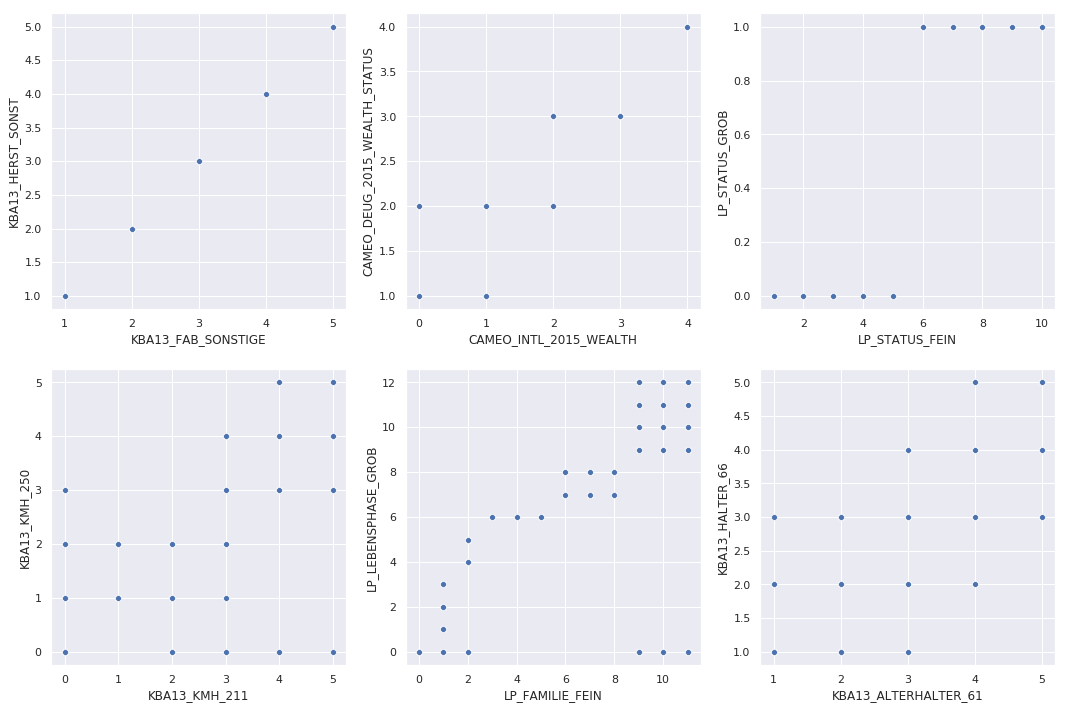

In [92]:
n_cols = 2
n_rows = 3
top_high_correlated = list(azdias_high_correlated_features.sort_values("correlation").tail(n_cols*n_rows)[["feature 1","feature 2"]].values)
plot_seaborn_grid_scatter_plot(azdias_step3,n_cols,n_rows,top_high_correlated)

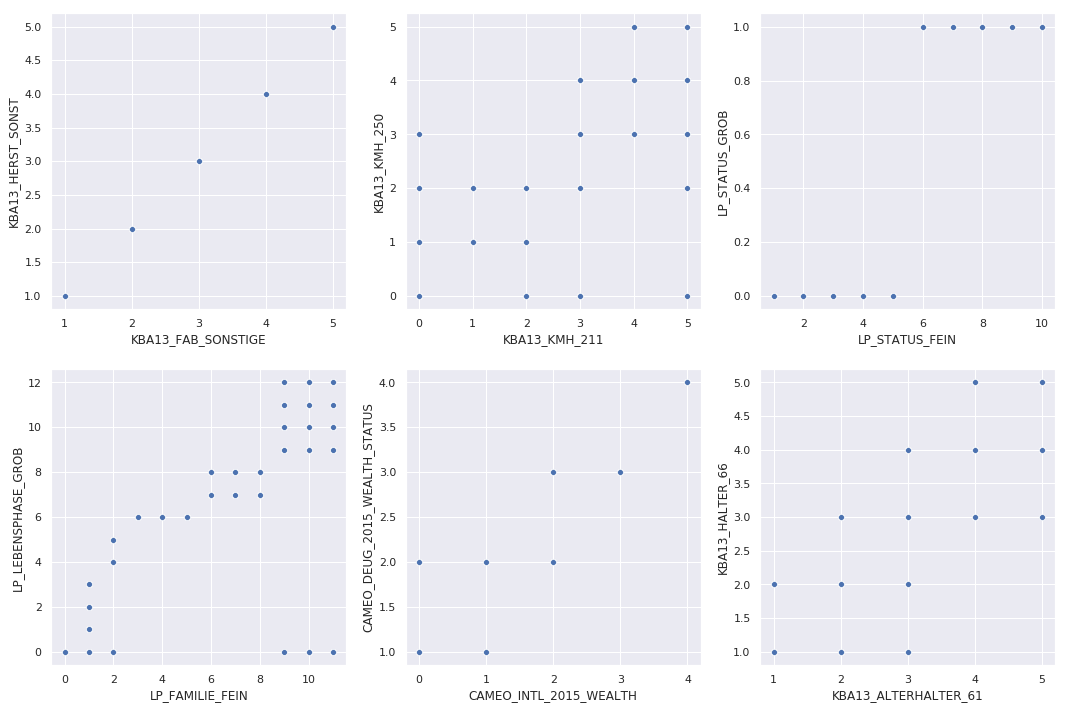

In [93]:
n_cols = 2
n_rows = 3
top_high_correlated = list(customers_high_correlated_features.sort_values("correlation").tail(n_cols*n_rows)[["feature 1","feature 2"]].values)
plot_seaborn_grid_scatter_plot(customers_step3,n_cols,n_rows,top_high_correlated)

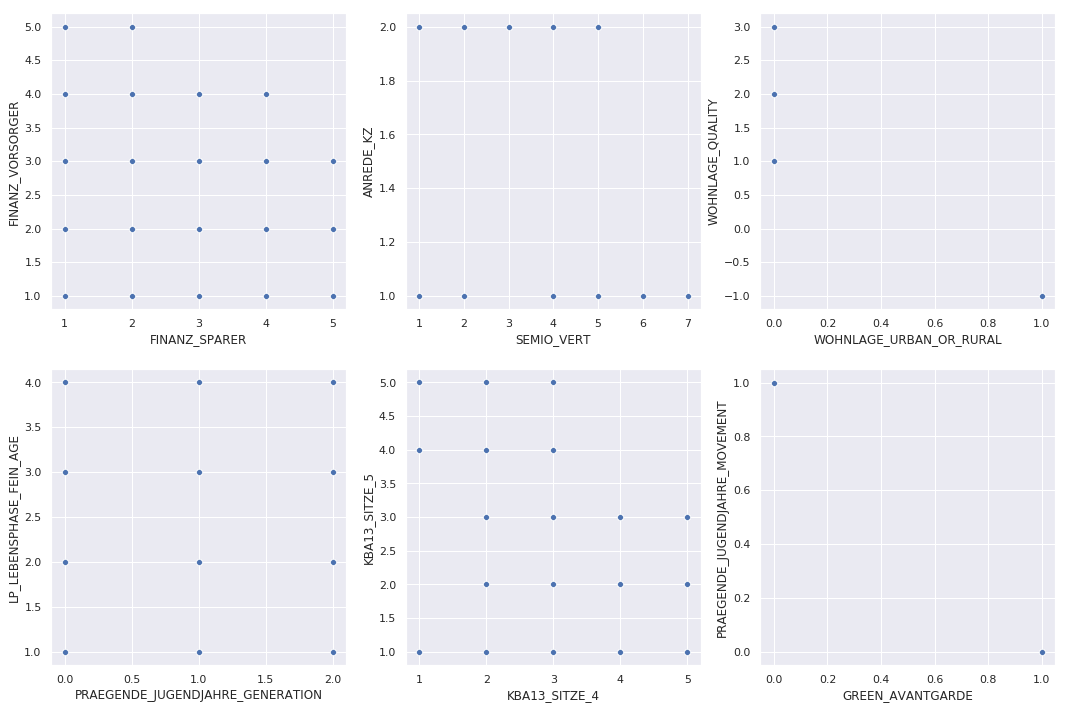

In [94]:
n_cols = 2
n_rows = 3
top_high_negative_correlated = list(azdias_high_correlated_features.sort_values("correlation").head(n_cols*n_rows)[["feature 1","feature 2"]].values)
plot_seaborn_grid_scatter_plot(azdias_step3,n_cols,n_rows,top_high_negative_correlated)

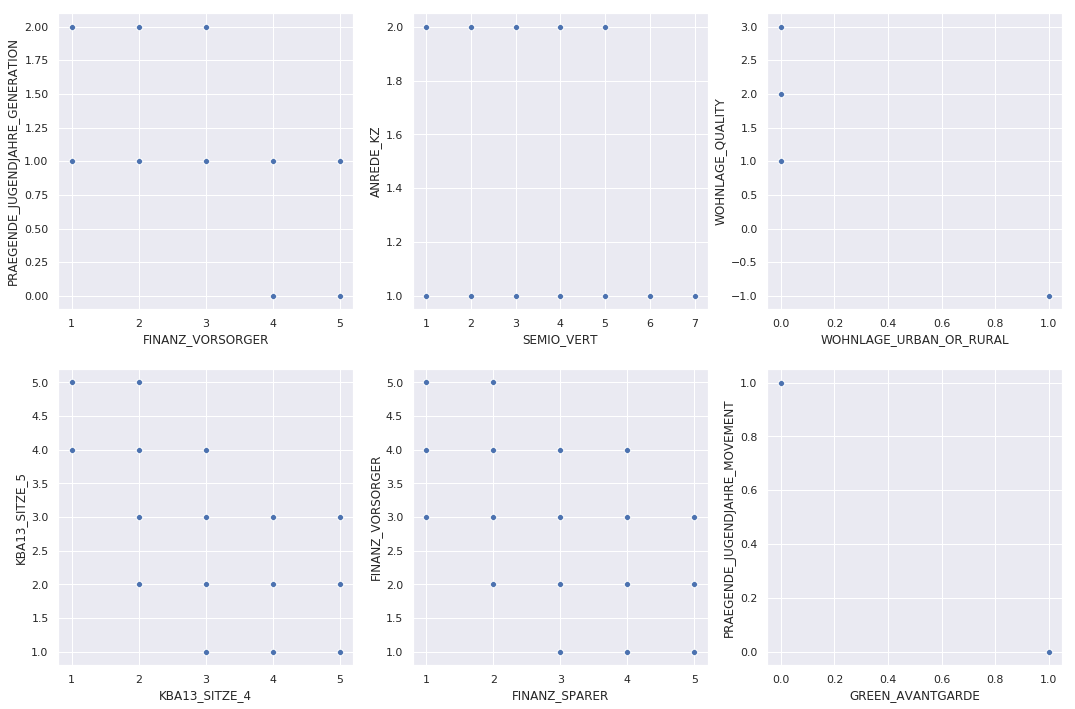

In [95]:
n_cols = 2
n_rows = 3
top_high_negative_correlated = list(customers_high_correlated_features.sort_values("correlation").head(n_cols*n_rows)[["feature 1","feature 2"]].values)
plot_seaborn_grid_scatter_plot(customers_step3,n_cols,n_rows,top_high_negative_correlated)

In [96]:
def clean_outiliers(df):
    outliers_removed = set()
    for column in df.columns:
        data_column = df[column].values 
        q25, q75 = np.percentile(data_column, 25), np.percentile(data_column, 75)
        print(column,q25,q75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        for index,x in enumerate(data_column):
            if(x >= lower and x <= upper):
                outliers_removed.add(index)
    print(outliers_removed)                                                               
        

In [97]:
# Impute nans using mode value

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias_step5 = imputer.fit_transform(azdias_step4)
azdias_step5 = pd.DataFrame(azdias_step5,columns=azdias_step4.columns)
azdias_step5 = azdias_step5.astype(float)

# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_step6 = scaler.fit_transform(azdias_step5)
azdias_step6 = pd.DataFrame(azdias_step6,columns=azdias_step5.columns)


In [98]:
azdias_step6.shape

(88701, 265)

In [99]:
# Impute nans using mode value
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
customers_step5= imputer.fit_transform(customers_step4)
customers_step5 = pd.DataFrame(customers_step5,columns=customers_step4.columns)
customers_step5 = customers_step5.astype(float)

# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
customers_step6 = scaler.fit_transform(customers_step5)
customers_step6 = pd.DataFrame(customers_step6,columns=customers_step5.columns)


In [100]:
set(azdias.columns)-set(azdias_step6.columns)

{'AGER_TYP',
 'ALTER_HH',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'GREEN_AVANTGARDE',
 'KBA05_BAUMAX',
 'KBA13_FAB_SONSTIGE',
 'KBA13_KMH_211',
 'KKK',
 'LP_FAMILIE_FEIN',
 'LP_LEBENSPHASE_FEIN',
 'OST_WEST_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'REGIOTYP',
 'TITEL_KZ',
 'WOHNLAGE'}

In [101]:
set(azdias_step6.columns)-set(azdias.columns)

{'CAMEO_DEUG_2015_WEALTH_STATUS',
 'CAMEO_INTL_2015_LIFE_STATING',
 'LP_LEBENSPHASE_FEIN_AGE',
 'LP_LEBENSPHASE_FEIN_WEALTH',
 'PRAEGENDE_JUGENDJAHRE_GENERATION',
 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
 'WOHNLAGE_QUALITY',
 'WOHNLAGE_URBAN_OR_RURAL'}

In [102]:
#azdias_step6.to_pickle("azdias_step6_reduced.pkl")
#customers_step6.to_pickle("customers_step6_reduced.pkl")

In [12]:
azdias_step6 = pd.read_pickle("azdias_step6.pkl")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [13]:
#pca model n componentes
def pca_model_n_components(df,n_components):
    pca = PCA(n_components)
    return pca,pca.fit_transform(df)

#pca model
def pca_model(df):
    pca = PCA()
    return pca,pca.fit_transform(df)
    
def get_min_components_variance(df,retain_variance):
    pca,pca_tranformed = pca_model(df)
    cumulative_sum = np.cumsum(pca.explained_variance_ratio_)
    return min(np.where(cumulative_sum>=retain_variance)[0]+1)

def plot_curve_min_components_variance(df,mode="cumulative_variance"):
    rcParams['figure.figsize'] = 12, 8

    
 
    pca,pca_transformed = pca_model(df)           
    fig = plt.figure()
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_sum = np.cumsum(explained_variance)
    
    n_components = len(explained_variance)
    ind = np.arange(n_components)
    
    
    ax = plt.subplot(111)
    if(mode=="cumulative_variance"):
        title = "Explained Cumulative Variance per Principal Component"
        ylabel = "Cumulative Variance (%)"
        ax.plot(ind, cumulative_sum)
        mark_1 = get_min_components_variance(df,0.2)
        mark_2 = get_min_components_variance(df,0.4)
        mark_3 = get_min_components_variance(df,0.6)
        mark_4 = get_min_components_variance(df,0.8)
        mark_5 = get_min_components_variance(df,0.9)
        mark_6 = get_min_components_variance(df,0.95)
        mark_7 = get_min_components_variance(df,0.99)





        plt.hlines(y=0.2, xmin=0, xmax=mark_1, color='green', linestyles='dashed',zorder=1)
        plt.hlines(y=0.4, xmin=0, xmax=mark_2, color='green', linestyles='dashed',zorder=2)
        plt.hlines(y=0.6, xmin=0, xmax=mark_3, color='green', linestyles='dashed',zorder=3)
        plt.hlines(y=0.8, xmin=0, xmax=mark_4, color='green', linestyles='dashed',zorder=4)
        plt.hlines(y=0.9, xmin=0, xmax=mark_5, color='green', linestyles='dashed',zorder=5)
        plt.hlines(y=0.95, xmin=0, xmax=mark_6, color='green', linestyles='dashed',zorder=6)
        plt.hlines(y=0.99, xmin=0, xmax=mark_7, color='green', linestyles='dashed',zorder=6)


        plt.vlines(x=mark_1, ymin=0, ymax=0.2, color='green', linestyles='dashed',zorder=7)
        plt.vlines(x=mark_2, ymin=0, ymax=0.4, color='green', linestyles='dashed',zorder=8)
        plt.vlines(x=mark_3, ymin=0, ymax=0.6, color='green', linestyles='dashed',zorder=9)
        plt.vlines(x=mark_4, ymin=0, ymax=0.8, color='green', linestyles='dashed',zorder=10)
        plt.vlines(x=mark_5, ymin=0, ymax=0.9, color='green', linestyles='dashed',zorder=11)
        plt.vlines(x=mark_6, ymin=0, ymax=0.95, color='green', linestyles='dashed',zorder=12)
        plt.vlines(x=mark_7, ymin=0, ymax=0.99, color='green', linestyles='dashed',zorder=12)
    else:
        title = "Variance per Principal Component"
        ylabel = "Variance (%)"
        ax.plot(ind, explained_variance)
    
        

    ax.set_xlabel("Number of principal components")
    ax.set_ylabel(ylabel)
    plt.title(title)
    
    
def plot_curve_k_mean(values):
    rcParams['figure.figsize'] = 12, 8

    fig = plt.figure()
    
    
    n_components = len(values)
    ind = np.arange(n_components) 
    ax = plt.subplot(111)
    title = "Variance per Principal Component"
    ylabel = "Variance (%)"
    ax.plot(ind, values)
    
    ax.set_xlabel("Number of principal components")
    ax.set_ylabel("AA")
    plt.title(title)  

#function to help interpret the pca results
def interpret_pca(df, n_components, component):
    rcParams['figure.figsize'] = 8, 8
    pca = PCA(n_components)
    df_pca = pca.fit_transform(df)
    
    df_pca = pd.DataFrame(columns=list(df.columns))
    df_pca.loc[0] = pca.components_[component]
    dim_index = "Dimension: {}".format(component + 1)

    df_pca.index = [dim_index]
    df_pca = df_pca.loc[:, df_pca.max().sort_values(ascending=False).index]

    ratio = np.round(pca.explained_variance_ratio_[component], 4)
    df_pca['Explained Variance'] = ratio

    cols = list(df_pca.columns)
    cols = cols[-1:] + cols[:-1]
    df_pca = df_pca[cols]

    return df_pca

#function to display interesting features
def report_features(feature_names,pca,component_number):
    '''
    This function displays interesting features of the selected dimension
    '''
    
    components = pca.components_
    
    feature_weights = dict(zip(feature_names, components[component_number]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    data = []
    
    
    for feature, weight, in sorted_weights:
        data.append([feature,weight])
    
    df =  pd.DataFrame(data,columns=["feature","weight"])    
    df.set_index("feature",inplace=True)
    return df
        
        
        
        
        
        

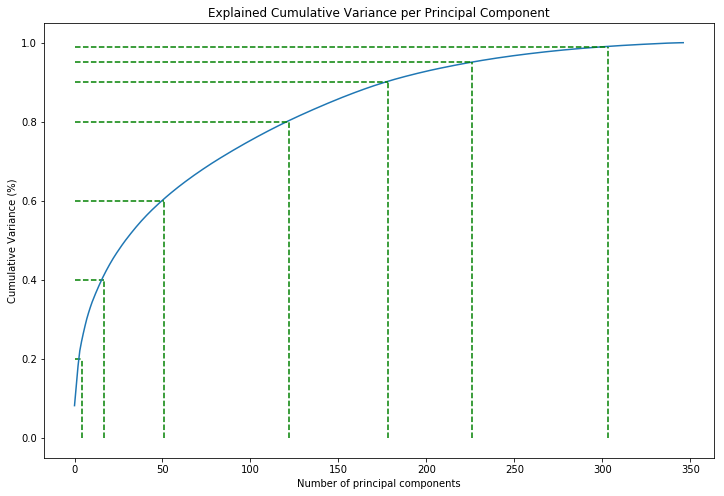

In [14]:
plot_curve_min_components_variance(azdias_step6,"cumulative_variance")

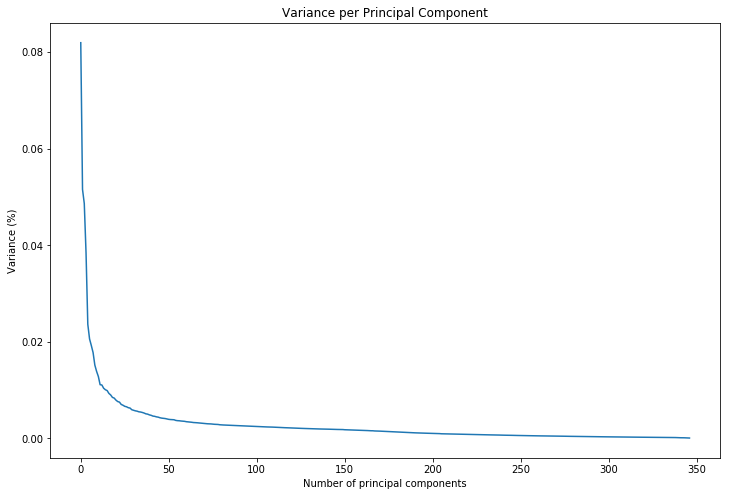

In [15]:
plot_curve_min_components_variance(azdias_step6,"explained_variance")

In [16]:
min_componentes_85 =  get_min_components_variance(azdias_step6,0.85)
min_componentes_90 =  get_min_components_variance(azdias_step6,0.90)
min_componentes_95 =  get_min_components_variance(azdias_step6,0.95)
min_componentes_99 =  get_min_components_variance(azdias_step6,0.99)
print("85% variance retained - ",min_componentes_85, " componentes")
print("90% variance retained - ",min_componentes_90, " componentes")
print("95% variance retained - ",min_componentes_95, " componentes")
print("99% variance retained - ",min_componentes_99, " componentes")

85% variance retained -  147  componentes
90% variance retained -  178  componentes
95% variance retained -  226  componentes
99% variance retained -  303  componentes


In [17]:
azdias_step6.shape

(88865, 347)

In [18]:
min_componentes_95 =  get_min_components_variance(azdias_step6,0.95)
azdias_pca_step7 , azdias_step7 = pca_model_n_components(azdias_step6,min_componentes_95)

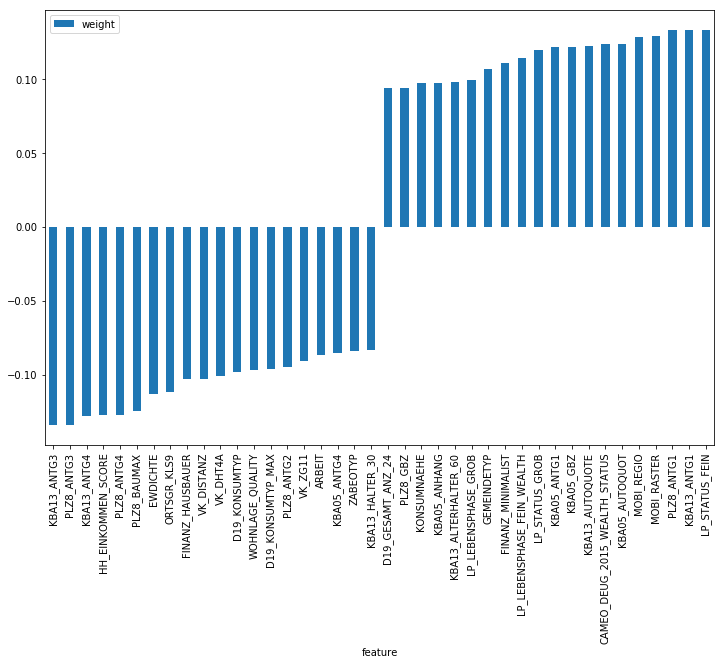

In [19]:
df_weights_pca = report_features(azdias_step6.columns,azdias_pca_step7,0)
df_weights_pca_sorted_head = df_weights_pca.sort_values("weight").head(20)
df_weights_pca_sorted_tail = df_weights_pca.sort_values("weight").tail(20)
top3_negative_component0 = df_weights_pca_sorted_head.head(3).index.values
top3_positive_component0 = df_weights_pca_sorted_tail.tail(3).index.values

df_weights_pca = pd.concat([df_weights_pca_sorted_head,df_weights_pca_sorted_tail])
df_weights_pca.plot(kind="bar")


In [109]:
print(list(top3_negative_component0))
print(list(top3_positive_component0))


['PLZ8_ANTG1', 'LP_STATUS_FEIN', 'MOBI_REGIO']
['PLZ8_ANTG4', 'PLZ8_ANTG3', 'HH_EINKOMMEN_SCORE']


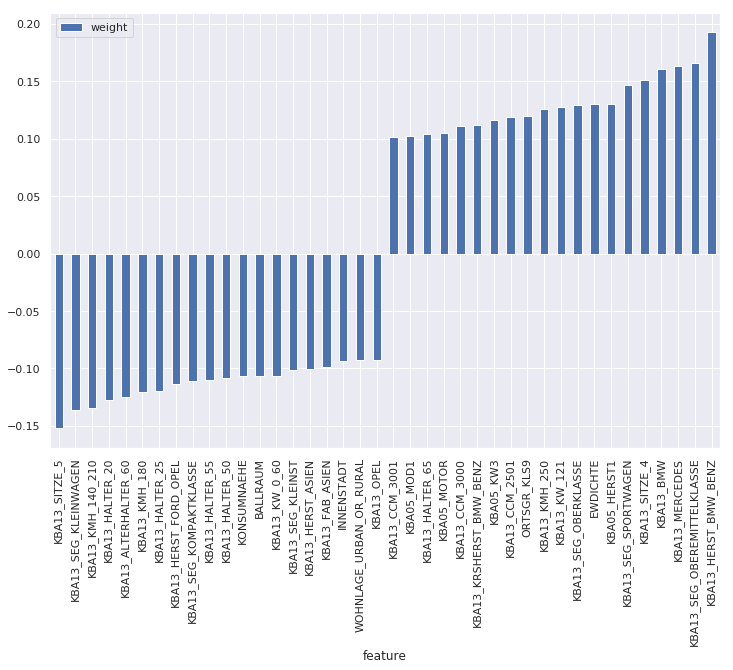

In [110]:
df_weights_pca = report_features(azdias_step6.columns,azdias_pca_step7,1)
df_weights_pca_sorted_head = df_weights_pca.sort_values("weight").head(20)
df_weights_pca_sorted_tail = df_weights_pca.sort_values("weight").tail(20)
top3_negative_component1 = df_weights_pca_sorted_head.head(3).index.values
top3_positive_component1 = df_weights_pca_sorted_tail.tail(3).index.values

df_weights_pca = pd.concat([df_weights_pca_sorted_head,df_weights_pca_sorted_tail])
df_weights_pca.plot(kind="bar")


In [111]:
print(list(top3_negative_component1))
print(list(top3_positive_component1))


['KBA13_SITZE_5', 'KBA13_SEG_KLEINWAGEN', 'KBA13_KMH_140_210']
['KBA13_MERCEDES', 'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_HERST_BMW_BENZ']


In [112]:
df_weights_pca_sorted_tail.tail(3).index.values

array(['KBA13_MERCEDES', 'KBA13_SEG_OBEREMITTELKLASSE',
       'KBA13_HERST_BMW_BENZ'], dtype=object)

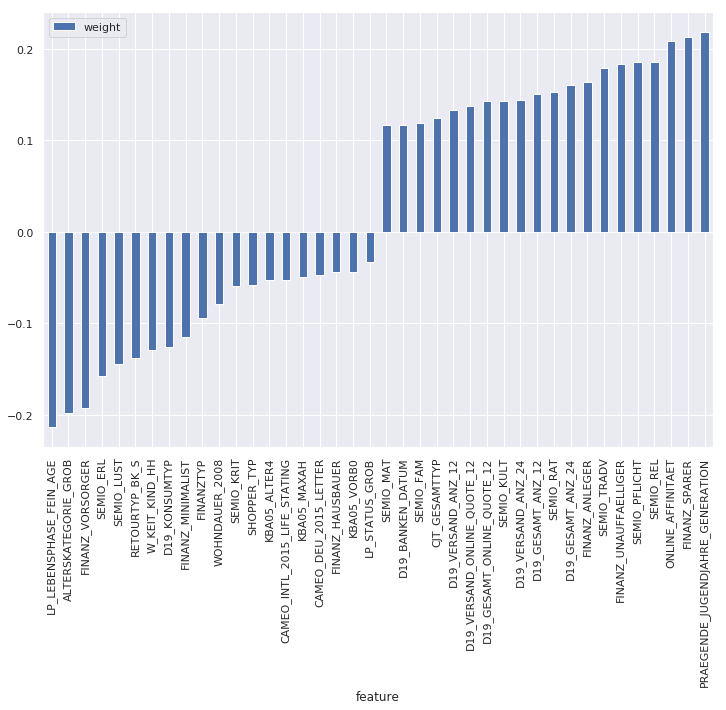

In [113]:
df_weights_pca = report_features(azdias_step6.columns,azdias_pca_step7,2)
df_weights_pca_sorted_head = df_weights_pca.sort_values("weight").head(20)
df_weights_pca_sorted_tail = df_weights_pca.sort_values("weight").tail(20)
top3_negative_component2 = df_weights_pca_sorted_head.head(3).index.values
top3_positive_component2 = df_weights_pca_sorted_tail.tail(3).index.values
df_weights_pca = pd.concat([df_weights_pca_sorted_head,df_weights_pca_sorted_tail])
df_weights_pca.plot(kind="bar")


In [114]:
print(list(top3_negative_component2))
print(list(top3_positive_component2))


['LP_LEBENSPHASE_FEIN_AGE', 'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER']
['ONLINE_AFFINITAET', 'FINANZ_SPARER', 'PRAEGENDE_JUGENDJAHRE_GENERATION']


In [115]:
list(top3_negative_component2)

['LP_LEBENSPHASE_FEIN_AGE', 'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER']

In [116]:
important_features = list()
important_features.extend(list(top3_negative_component0))
important_features.extend(list(top3_positive_component0))
important_features

['PLZ8_ANTG1',
 'LP_STATUS_FEIN',
 'MOBI_REGIO',
 'PLZ8_ANTG4',
 'PLZ8_ANTG3',
 'HH_EINKOMMEN_SCORE']

In [117]:
important_features = list()
important_features.extend(list(top3_negative_component0))
important_features.extend(list(top3_positive_component0))
important_features

['PLZ8_ANTG1',
 'LP_STATUS_FEIN',
 'MOBI_REGIO',
 'PLZ8_ANTG4',
 'PLZ8_ANTG3',
 'HH_EINKOMMEN_SCORE']

In [21]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [22]:
cost =[] 
max_clusters = 20
for i in range(2, max_clusters):
    print("Analysing ", i, " clusters")
    KM = MiniBatchKMeans(n_clusters = i,batch_size=20000) 
    KM.fit(azdias_step7) 
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)    
  
# plot the cost against K values 
plt.plot(range(2, max_clusters), cost, color ='g', linewidth ='3') 
plt.xlabel("Number of Clusters") 
plt.ylabel("Squared Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

Analysing  2  clusters
Analysing  3  clusters


KeyboardInterrupt: 

In [23]:
number_clusters = 10
kmeans = KMeans(number_clusters)
fitted_model_k_means = kmeans.fit(azdias_step7)

In [121]:
azdias_step6["cluster_number"] = list(fitted_model_k_means.labels_)

In [122]:
customers_step6.shape

(36781, 265)

In [123]:
customers_step7 = azdias_pca_step7.transform(customers_step6)
customers_step6["cluster_number"] = fitted_model_k_means.predict(customers_step7)

In [124]:
customers_step6.groupby(["cluster_number"])["AKT_DAT_KL"].count()

KeyError: 'Column not found: AKT_DAT_KL'

In [125]:
clusters_customers_percent = customers_step6.groupby(["cluster_number"])["AKT_DAT_KL"].count().reset_index().rename(columns = {"AKT_DAT_KL":"%"})
clusters_customers_percent["%"] = clusters_customers_percent["%"]/len(customers_step6)*100

KeyError: 'Column not found: AKT_DAT_KL'

In [126]:
clusters_customers_percent

NameError: name 'clusters_customers_percent' is not defined

In [ ]:
clusters_azdias_percent = azdias_step6.groupby(["cluster_number"])["AKT_DAT_KL"].count().reset_index().rename(columns = {"AKT_DAT_KL":"%"})
clusters_azdias_percent["%"] = clusters_azdias_percent["%"]/len(azdias_step6)*100

In [ ]:
ax = sns.barplot(x="cluster_number",y = "%", data=clusters_azdias_percent)

In [ ]:
ax = sns.barplot(x="cluster_number",y = "%", data=clusters_customers_percent)

In [ ]:
clusters_customers_percent["type"]="custumers"
clusters_azdias_percent["type"]="general_population"
clusters = pd.concat([clusters_customers_percent,clusters_azdias_percent])

ax = sns.barplot(x="cluster_number",y = "%", hue="type", data=clusters)


In [ ]:



ax = sns.barplot(y = clusters_customers_percent.sort_values("cluster_number")["%"]-clusters_azdias_percent.sort_values("cluster_number")["%"],x = clusters_customers_percent.sort_values("cluster_number")["cluster_number"], data=clusters_customers_percent)


In [ ]:
most_diference_clusters = [2,3,7,8]
most_equal_clusters = [0,2,5,6]

In [ ]:
import squarify


In [ ]:
import matplotlib

volume = clusters_customers_percent.sort_values(["cluster_number"])["%"].values
labels = clusters_customers_percent.sort_values(["cluster_number"])["cluster_number"].values

norm = matplotlib.colors.Normalize(vmin=min(volume), vmax=max(volume))

color_list = [matplotlib.cm.Blues(norm(value)) for value in volume]

plt.rc('font', size=14)
squarify.plot(sizes=volume, label=labels,
              color=color_list, alpha=0.7)
plt.axis('off')

plt.show()

In [ ]:
import matplotlib

volume = clusters_azdias_percent.sort_values(["cluster_number"])["%"].values
labels = clusters_azdias_percent.sort_values(["cluster_number"])["cluster_number"].values

norm = matplotlib.colors.Normalize(vmin=min(volume), vmax=max(volume))

color_list = [matplotlib.cm.Blues(norm(value)) for value in volume]

plt.rc('font', size=14)
squarify.plot(sizes=volume, label=labels,
              color=color_list, alpha=0.7)
plt.axis('off')

plt.show()

In [ ]:
clusters_customers_percent = customers_step6.groupby(["cluster_number"])["AKT_DAT_KL"].count().reset_index().rename(columns = {"AKT_DAT_KL":"%"})
clusters_customers_percent["%"] = clusters_customers_percent["%"]/len(customers_step6)*100


In [ ]:
azdias_important_clusters = azdias_step6.groupby("cluster_number")[important_features].mean().reset_index()
custumers_important_clusters = customers_step6.groupby("cluster_number")[important_features].mean().reset_index()
azdias_important_clusters["type"]="general_population"
custumers_important_clusters["type"]="custumers"

important_clusters = pd.concat([azdias_important_clusters,custumers_important_clusters])

In [ ]:
azdias_step5["cluster_number"] = azdias_step6["cluster_number"]
customers_step5["cluster_number"] = customers_step6["cluster_number"]

f, axes = plt.subplots(len(most_equal_clusters), len(important_features), figsize=(30, 20), sharex=True)


for i,feature in enumerate(important_features):
    for j,cluster in enumerate(most_equal_clusters):
        azdias_cluster = azdias_step5[azdias_step5["cluster_number"]==cluster]
        custumer_cluster = customers_step5[customers_step5["cluster_number"]==cluster]
        azdias_important_clusters = azdias_cluster.groupby([feature])["AKT_DAT_KL"].count().reset_index().rename(columns={"AKT_DAT_KL":"%"})
        azdias_important_clusters["%"] = azdias_important_clusters["%"]/len(azdias_cluster)
        custumer_important_clusters = custumer_cluster.groupby([feature])["AKT_DAT_KL"].count().reset_index().rename(columns={"AKT_DAT_KL":"%"})
        custumer_important_clusters["%"] = custumer_important_clusters["%"]/len(custumer_cluster)
        azdias_important_clusters["type"]="general_population"
        custumer_important_clusters["type"]="custumers"
        important_clusters = pd.concat([azdias_important_clusters,custumer_important_clusters])
        sns.barplot(x=feature,y="%",hue="type",data=important_clusters, ax=axes[j, i])

f.savefig("most-equal-features.png")





In [ ]:
azdias_step5["cluster_number"] = azdias_step6["cluster_number"]
customers_step5["cluster_number"] = customers_step6["cluster_number"]

f, axes = plt.subplots(len(most_equal_clusters), len(important_features), figsize=(30, 20), sharex=True)


for i,feature in enumerate(important_features):
    for j,cluster in enumerate(most_diference_clusters):
        azdias_cluster = azdias_step5[azdias_step5["cluster_number"]==cluster]
        custumer_cluster = customers_step5[customers_step5["cluster_number"]==cluster]
        azdias_important_clusters = azdias_cluster.groupby([feature])["AKT_DAT_KL"].count().reset_index().rename(columns={"AKT_DAT_KL":"%"})
        azdias_important_clusters["%"] = azdias_important_clusters["%"]/len(azdias_cluster)
        custumer_important_clusters = custumer_cluster.groupby([feature])["AKT_DAT_KL"].count().reset_index().rename(columns={"AKT_DAT_KL":"%"})
        custumer_important_clusters["%"] = custumer_important_clusters["%"]/len(custumer_cluster)
        azdias_important_clusters["type"]="general_population"
        custumer_important_clusters["type"]="custumers"
        important_clusters = pd.concat([azdias_important_clusters,custumer_important_clusters])
        sns.barplot(x=feature,y="%",hue="type",data=important_clusters, ax=axes[j, i])

f.savefig("most-difference-features.png")

    




## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [50]:
from sklearn.utils import resample


In [51]:
def transform_and_scale(df,imputer_strategy="most_frequent"):    
    df = df.astype(float)
    imputer = SimpleImputer(missing_values=np.nan,strategy=imputer_strategy)
    df_imputed = imputer.fit_transform(df)
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_imputed)
    return df_scaled

In [52]:
mailout_train = pd.read_csv('train.csv', sep=';')

/home/lexlabs/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
df_majority = mailout_train[mailout_train["RESPONSE"]==0].reset_index()
df_minority = mailout_train[mailout_train["RESPONSE"]==1].reset_index()

In [55]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(len(mailout_train)*0.8),     # to match minority class
                                 random_state=123) # reproducible results

In [56]:
mailout_train = pd.concat([df_majority_downsampled,df_minority]).reset_index().sample(frac=1)

In [57]:
mailout_test = pd.read_csv('test.csv', sep=';')

/home/lexlabs/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
response = mailout_train["RESPONSE"]
del  mailout_train["RESPONSE"]


In [59]:
mailout_train_processed = pre_processing(mailout_train)
mailout_test_processed = pre_processing(mailout_test)


mailout_train_mapped  = map_to_unkown(mailout_train_processed)
mailout_test_mapped  = map_to_unkown(mailout_test_processed)

mail_train_eng = feature_eng(mailout_train_mapped)
mail_test_eng = feature_eng(mailout_test_mapped)


columns_to_drop  =  set(mail_train_eng.columns)-set(azdias_step6.columns)


for column in columns_to_drop:
    if column in mail_train_eng.columns:
        mail_train_eng.drop(columns=column,inplace=True)
        
        
for column in columns_to_drop:
    if column in mail_test_eng.columns:
        mail_test_eng.drop(columns=column,inplace=True)
        
        
mail_train_eng = mail_train_eng.astype(float)
mail_test_eng = mail_test_eng.astype(float)


x_train = transform_and_scale(mail_train_eng,imputer_strategy="most_frequent")
y_train = response


x_test = transform_and_scale(mail_test_eng,imputer_strategy="most_frequent")

0  rows processed
1000  rows processed
2000  rows processed
3000  rows processed
4000  rows processed
5000  rows processed
6000  rows processed
7000  rows processed
8000  rows processed
9000  rows processed
10000  rows processed
11000  rows processed
12000  rows processed
13000  rows processed
14000  rows processed
15000  rows processed
16000  rows processed
17000  rows processed
18000  rows processed
19000  rows processed
20000  rows processed
21000  rows processed
22000  rows processed
23000  rows processed
24000  rows processed
25000  rows processed
26000  rows processed
27000  rows processed
28000  rows processed
29000  rows processed
30000  rows processed
31000  rows processed
32000  rows processed
33000  rows processed
34000  rows processed
0  rows processed
1000  rows processed
2000  rows processed
3000  rows processed
4000  rows processed
5000  rows processed
6000  rows processed
7000  rows processed
8000  rows processed
9000  rows processed
10000  rows processed
11000  rows pr

In [60]:
x_train.shape

(34901, 347)

In [133]:
x_train_pca = x_train.copy()
x_test_pca = x_test.copy()

In [61]:
df_x_train = pd.DataFrame(x_train)
mail_train_eng_transformed = azdias_pca_step7.transform(x_train)
df_x_train["cluster_number"] = fitted_model_k_means.predict(mail_train_eng_transformed)/9
x_train = df_x_train.values


df_x_test = pd.DataFrame(x_test)
mail_test_eng_transformed = azdias_pca_step7.transform(x_test)
df_x_test["cluster_number"] = fitted_model_k_means.predict(mail_test_eng_transformed)/9
x_test = df_x_test.values

In [ ]:
mail_train_eng_transformed = azdias_pca_step7.transform(x_train_pca)
df_x_train_pca = pd.DataFrame(mail_train_eng_transformed)
df_x_train_pca["cluster_number"] = fitted_model_k_means.predict(mail_train_eng_transformed)/9
x_train_pca = df_x_train_pca.values



mail_test_eng_transformed = azdias_pca_step7.transform(x_test_pca)
df_x_test_pca = pd.DataFrame(mail_test_eng_transformed)
df_x_test_pca["cluster_number"] = fitted_model_k_means.predict(mail_test_eng_transformed)/9
x_test_pca = df_x_test_pca.values



In [ ]:
df_x_train["cluster_number"] = df_x_train["cluster_number"]*9
df_x_train["response"] = y_train
df_mailout = df_x_train.groupby(["cluster_number","response"]).count()[0].reset_index().rename(columns={0:"count"})
rcParams['figure.figsize'] = 12, 8
sns.countplot(x="cluster_number",data=df_x_train)

In [ ]:
rcParams['figure.figsize'] = 12, 8

sns.barplot(x="cluster_number",y="count",hue="response",data=df_mailout[df_mailout["response"]==1])

In [ ]:
rcParams['figure.figsize'] = 12, 8

sns.barplot(x="cluster_number",y="count",hue="response",data=df_mailout[df_mailout["response"]==0])

In [66]:
cv = model_selection.StratifiedKFold(n_splits=3)


In [ ]:
x_baseline = process_transform_scale(mailout_train[features],columns_to_drop,"most_frequent",False)

In [ ]:
sm = SMOTE(random_state=12,sampling_strategy=0.03)
x_res_cluster, y_train_res_cluster = sm.fit_sample(x_train_cluster, y_train)

In [136]:
pickle.dump(x_train, open("x_train_reduced.pkl","wb"))
pickle.dump(y_train, open("y_train_reduced.pkl","wb"))
#x_train = pickle.load(open("x_train.pkl","rb"))
#y_train = pickle.load(open("y_train.pkl","rb"))

In [ ]:
#pickle.dump(x_res_cluster, open("x_res.pkl","wb"))
#pickle.dump(y_train_res, open("y_train_res.pkl","wb"))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_true,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)
    return class_report_df    

In [62]:
def plot_learning_curve(estimator, 
                        title, 
                        X, 
                        y, 
                        ylim=None, 
                        cv=None,
                        n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(16,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator, 
                                                            X, y, cv=cv, 
                                                            n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                            scoring="roc_auc")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")


    plt.legend(loc="best")
    return plt

In [63]:
params_xgboost = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.01, 0.1, 1.0],
        'max_depth': [3, 10, 30],
        'n_estimators': [200,500,800],
        'max_delta_step':[0,5,10,15,20],
        'scale_pos_weight': [1,40,80]
        }

clf_xgb = xgb.XGBClassifier(
        objective = 'binary:logistic',
        eval_metric = 'auc',
    )


In [91]:
params_rf = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 2000],
 'class_weight' :['balanced','balanced_subsample',None]}

from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()

In [73]:
params_lr = {
    'penalty':['l1', 'l2', 'elasticnet'],        # l1 is Lasso, l2 is Ridge
    'solver':['liblinear'],
    'C': np.linspace(0.00002,1,100),
    'class_weight':["balanced",None]
}

from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()

In [65]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


def do_grid_search(model,params,cv, x_train, y_train):
   grid = RandomizedSearchCV(model,params, scoring = 'roc_auc', cv=cv,n_jobs=-1,verbose=10,n_iter=300).fit(x_train,y_train)
   return grid



In [67]:
start_time = timer(None) # timing starts from this point for "start_time" variable
xgboost_grid_downsample = do_grid_search(clf_xgb,params_xgboost,cv, x_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 51.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 53.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 60.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 70.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 79


 Time taken: 6 hours 10 minutes and 36.21 seconds.


In [68]:
pickle.dump(xgboost_grid_downsample, open("xgboost_grid_downsample.pkl","wb"))


In [74]:
start_time = timer(None) # timing starts from this point for "start_time" variable
lr_grid_downsample = do_grid_search(clf_lr,params_lr,cv, x_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8


 Time taken: 0 hours 59 minutes and 20.43 seconds.


In [75]:
pickle.dump(lr_grid_downsample, open("lr_grid_1_downsample.pkl","wb"))


In [92]:
start_time = timer(None) # timing starts from this point for "start_time" variable
rf_grid_downsample = do_grid_search(clf_rf,params_rf,cv, x_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.6min
/home/lexlabs/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 30.0min
[Parallel(n_job


 Time taken: 5 hours 18 minutes and 3.21 seconds.


In [93]:
pickle.dump(rf_grid_downsample, open("rf_grid_1_downsample.pkl","wb"))
#rf_grid = pickle.(open("rf_grid_1.pkl","rb"))

In [145]:
pickle.dump(lr_grid, open("lr_grid_1_reduced.pkl","wb"))
#pickle.dump(lr_grid, open("lr_grid_1.pkl","wb"))
#lr_grid = pickle.load(open("lr_grid_1_reduced.pkl","rb"))

In [20]:
#pickle.dump(xgboost_grid, open("xgboost_grid_1.pkl","wb"))
#xgboost_grid = pickle.load(open("xgboost_grid_1.pkl","rb"))

In [ ]:
#start_time = timer(None) # timing starts from this point for "start_time" variable
#xgboost_grid_negative_resampling = do_grid_search(clf_xgb,params_xgboost,cv, x_train_, y_train)
#timer(start_time) # timing ends here for "start_time" variable

In [ ]:
#start_time = timer(None) # timing starts from this point for "start_time" variable
#xgboost_grid3 = do_grid_search(clf_xgb,params_xgboost,cv, x_train_pca, y_train)
#timer(start_time) # timing ends here for "start_time" variable

In [ ]:
#import pickle
#pickle.dump(xgboost_grid3, open("xgboost_grid3.pickle","wb"))

<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

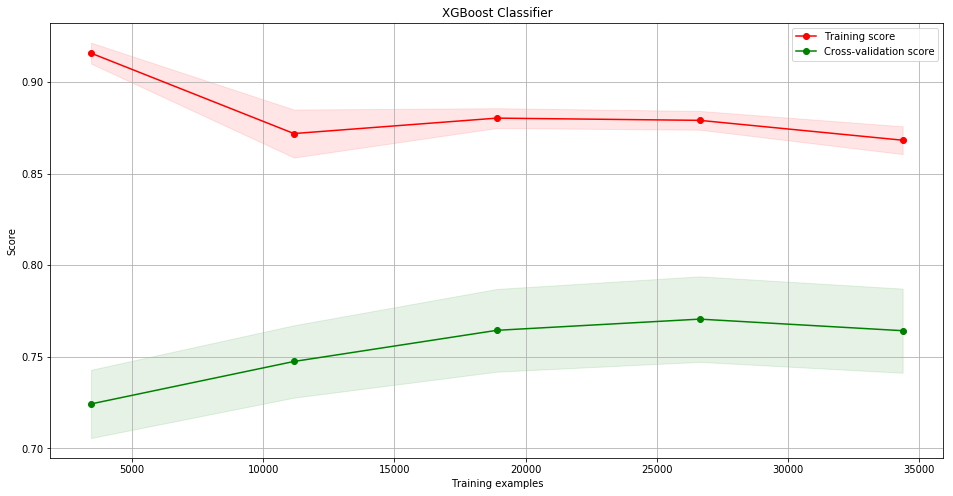

In [23]:
plot_learning_curve(xgboost_grid.best_estimator_, 
                        "XGBoost Classifier", 
                        x_train, 
                        y_train)

<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

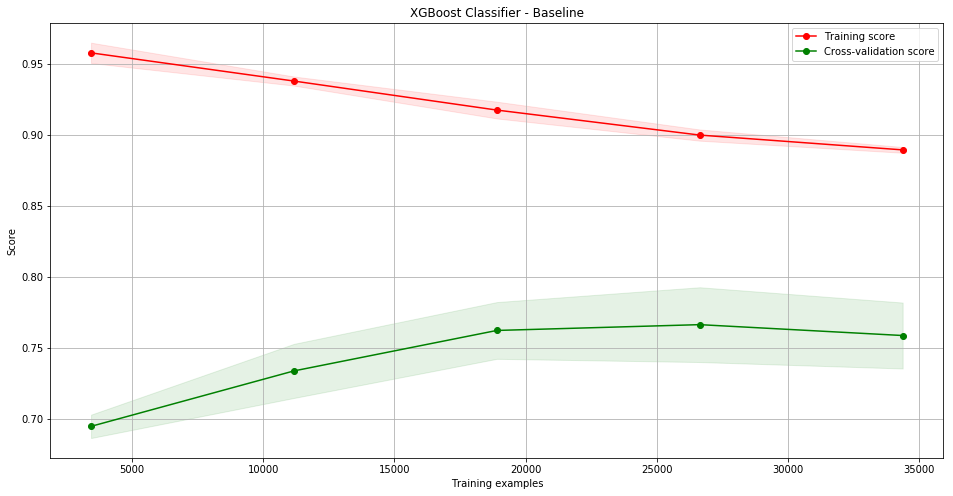

In [28]:
xgboost_baseline = base_models[2][1]
plot_learning_curve(xgboost_baseline, 
                        "XGBoost Classifier - Baseline", 
                        x_train, 
                        y_train)

<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

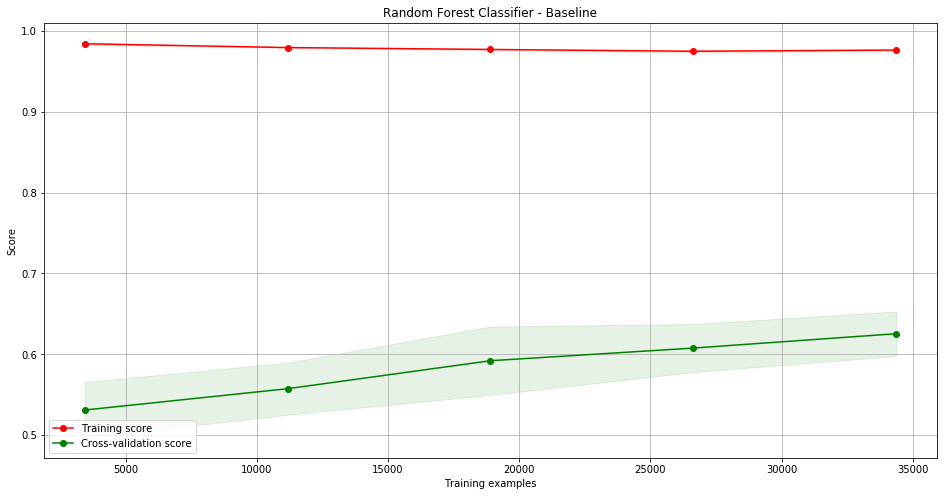

In [29]:
xgboost_baseline = base_models[1][1]
plot_learning_curve(xgboost_baseline, 
                        "Random Forest Classifier - Baseline", 
                        x_train, 
                        y_train)

In [36]:
sm = SMOTE(random_state=12,sampling_strategy=0.03)
x_res, y_train_res = sm.fit_sample(x_train, y_train)

In [ ]:
params_xgboost = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.01, 0.1, 1.0],
        'max_depth': [3, 10, 30],
        'n_estimators': [200,500,800],
        'max_delta_step':[0,5,10,15,20],
        'scale_pos_weight': [1,40,80]
        }

clf_xgb = xgb.XGBClassifier(
        objective = 'binary:logistic',
        eval_metric = 'auc',
    )

start_time = timer(None) # timing starts from this point for "start_time" variable
xgboost_expanded_grid = do_grid_search(clf_xgb,params_xgboost,cv, x_res, y_train_res)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 50.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 65.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 73.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 80.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 86.5min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 93.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 98

In [ ]:
pickle.dump(xgboost_expanded_grid,open("xgboost_expanded_grid.pkl","wb"))

In [ ]:
#pickle.dump(x_train_pca,open("x_train_pca","wb"))
#pickle.dump(y_train,open("y_train","wb"))

In [ ]:
#x_train_pca = pickle.load(open("x_train_pca","rb"))
#y_train = pickle.load(open("y_train","rb"))
#xgboost_grid3 = pickle.load(open("xgboost_grid3.pickle","rb"))


In [ ]:
#plot_learning_curve(lr_grid.best_estimator_, 
#                        "XGBoost Classifier + PCA", 
#                        x_train_pca, 
                        y_train)#

In [ ]:

plot_learning_curve(model, 
                        "XGBoost Classifier", 
                        x_train, 
                        y_train)

In [ ]:
plot_confusion_matrix(clf_decision_tree["confusion_matrix"], ["0","1"])

In [ ]:
param_grid= {
        'min_child_weight': [1, 5, ],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        }
model = xgb.XGBClassifier()

cv = model_selection.StratifiedKFold(n_splits=3)
clf_xgboost = model_fit_transform_and_eval(model,param_grid,cv, X_traincv, y_traincv, X_testcv, y_testcv)



cv = model_selection.StratifiedKFold(n_splits=5)
clf_xgboost2 = model_fit_transform_and_eval(model,param_grid,cv, X_traincv, y_traincv, X_testcv, y_testcv)

In [ ]:
clf_xgboost2["model_report"]

In [ ]:
clf_xgboost1["model_report"]

In [ ]:
import pickle

save_classifier = open("clf_xgboost2.pickle","wb")
pickle.dump(clf_xgboost2, save_classifier)
save_classifier.close()

save_classifier = open("clf_xgboost2.pickle","wb")
pickle.dump(clf_xgboost1, save_classifier)
save_classifier.close()


In [ ]:
!pip install scikit-optimize

In [ ]:
def hyper_paramter_tuning(model,params,type_searching,scoring,cv,ITERATIONS):
    if(params=="BayesSearchCV"):
         estimator = BayesSearchCV(
                estimator = estimator,
                search_spaces = params,
                scoring = scoring,
                cv = cv
                n_jobs = -1,
                n_iter = ITERATIONS,   
                verbose = 0,
                refit = True,
                random_state = np.random.RandomState(50)
        )
    if(params=="RandomizedSearch"):
         GridSearchCV(model,
                      params, 
                      scoring = scoring, 
                      cv=cv,
                      n_jobs=-1,
                      verbose=0)


In [ ]:
negative = len(y_train)-sum(y_train)
positive = sum(y_train)

In [ ]:
scale_pos_weight1 = negative/positive
scale_pos_weight2 = math.sqrt(negative)/positive

In [ ]:
scale_pos_weight1

In [ ]:
# Classifier

ITERATIONS = 30 

import pandas as pd
import numpy as np
import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = -1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (200, 500),
        'scale_pos_weight': (1e-6, 80, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    print("status_print")
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [ ]:
bayes_cv_tuner.fit(x_train, y_train, callback=status_print)

In [ ]:
bayes_xgb = bayes_cv_tuner_xg.best_estimator_
y_pred = bayes_xgb.predict(X_testcv)
best_model_report = class_report(y_testcv, y_pred)

In [ ]:
import pickle

pickle.dump(bayes_xgb, open("bayes_xgb.pkl", 'wb'))

In [ ]:
plot_learning_curve(bayes_xgb, 
                        "", 
                        x, 
                        y)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

LogisticRegression(C=0.03032242424242424, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [94]:
xgb = rf_grid_downsample.best_estimator_
response = xgb.predict_proba(x_test)[:,1]

In [95]:
mailout_test["RESPONSE"] = response

mailout_test["RESPONSE"].to_csv("response12.csv")

/home/lexlabs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_response.to_csv("response2.csv")

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
         
}
,

from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
models = ["Base Model","XgBoost", "XgBoost + PCA"]
results_kaggle = [0.79053,0.792040,0.63445]
sns.barplot(x=models,y=results_kaggle).set_ylim([0.5,1.0])



In [ ]:
model = BalancedRandomForestClassifier()


In [ ]:
del plt.title

In [152]:
def create_base_models():
    '''
    Creates base models.
    
    Args:
        None
    
    Returns:
        baseModels (list) - list containing base models.
    '''
    
    SEED = 42
    basedModels = []
    basedModels.append(('LR', LogisticRegression(solver='liblinear', random_state=SEED)))
    basedModels.append(('RF', RandomForestClassifier(n_estimators=250, random_state=SEED)))
    basedModels.append(('XGB', XGBClassifier(random_state=SEED)))
    
    return basedModels

In [153]:
base_models = create_base_models()

for base_model in base_models:
    print(base_model[0])
    base_model[1].fit(x_train,y_train)

NameError: name 'XGBClassifier' is not defined

In [25]:
for base_model in base_models:
     model = base_model[1]
     response = model.predict_proba(x_test)[:,1]
     mailout_test["RESPONSE"] = response
     mailout_test["RESPONSE"].to_csv("response_base_model_"+base_model[0]+".csv")

/home/lexlabs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """
/home/lexlabs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


In [59]:
xgboost_grid.best_estimator_.feature_importances_.shape


(348,)

In [62]:
mail_train_eng.shape

(42962, 347)